# 🌍 Seismic Imaging Course – 2025 Edition
### Numerical Modeling & Inversion (2/3)
**Professor:** Nicola Bienati

**Author:** Felipe Rincón  
*PhD Student in Geophysics*  
📧 felipe.rincon@phd.unipi.it  

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_65644/1152811897.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


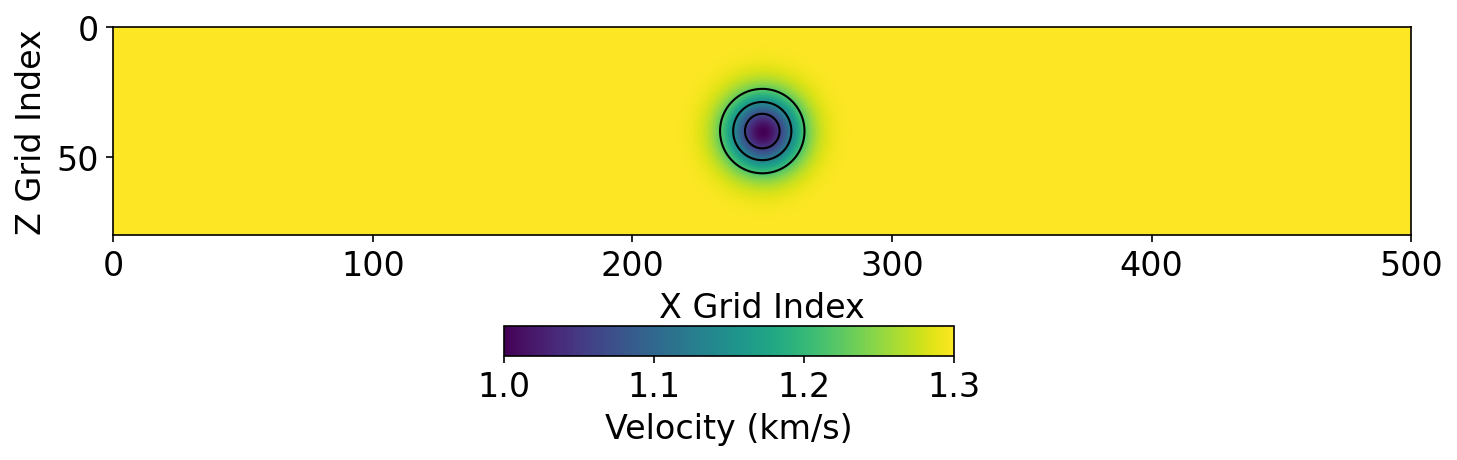

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seismic_utils import (
    generate_source_locations,
    generate_receiver_coordinates,
    plot_shotrecord2,
    compute_residual,
    fwi_gradient,
    plot_velocity_clim,
    Model,
    configuration,
    AcquisitionGeometry,
    AcousticWaveSolver,
    mmax,
    compute_update
)

# Define model parameters
nx, nz = 500, 80
v0 = 1.3  # Background velocity
velocity = np.full((nz, nx), v0, dtype=float)

# Gaussian anomaly parameters
cx, cz = nx // 2, nz // 2  # Center of anomaly
sigma = 10                 # Controls spread of the Gaussian
perturbation = 0.3         # Amplitude of velocity reduction

# Generate coordinate grids
x = np.arange(nx)
z = np.arange(nz)
X, Z = np.meshgrid(x, z)

gaussian = perturbation * np.exp(-((X - cx)**2 + (Z - cz)**2) / (2 * sigma**2))
velocity -= gaussian

# Plotting
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(velocity, cmap="viridis", origin="lower", extent=[0, nx, 0, nz])
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Z Grid Index")

# Optional: overlay a contour to visualize the anomaly boundary
cs = ax.contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

# Colorbar
cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

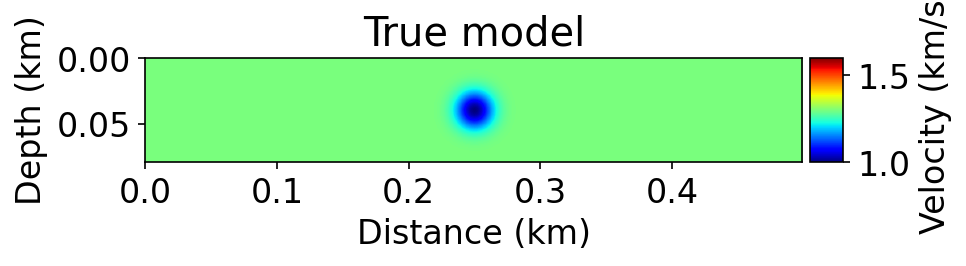

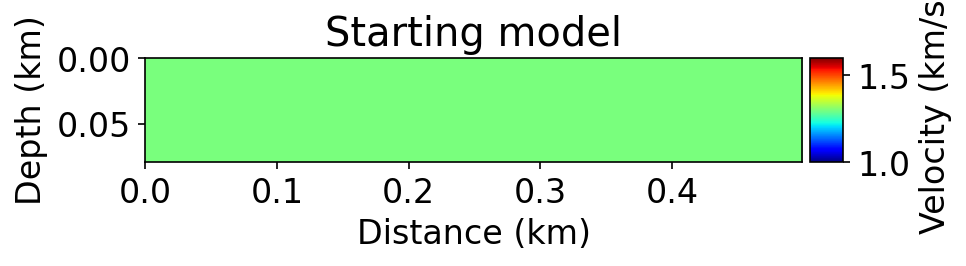

In [2]:
configuration['log-level'] = 'WARNING'
nshots = 1  # Number of shots
nreceivers = 1  # Number of receivers
fwi_iterations = 1  # Number of iterations

# Define true and initial model
shape = (500, 80)  # Number of grid point (nx, nz)
spacing = (1, 1) #in meters
origin = (0., 0.) 

v=np.transpose(velocity)
nbl=20
true_model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(true_model, vmin=v0-perturbation, vmax=v0+perturbation, name="True model", cmap="jet")

#create an starting model
v2=np.ones(shape)*v0
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(start_model, vmin=v0-perturbation, vmax=v0+perturbation, name="Starting model", cmap="jet")

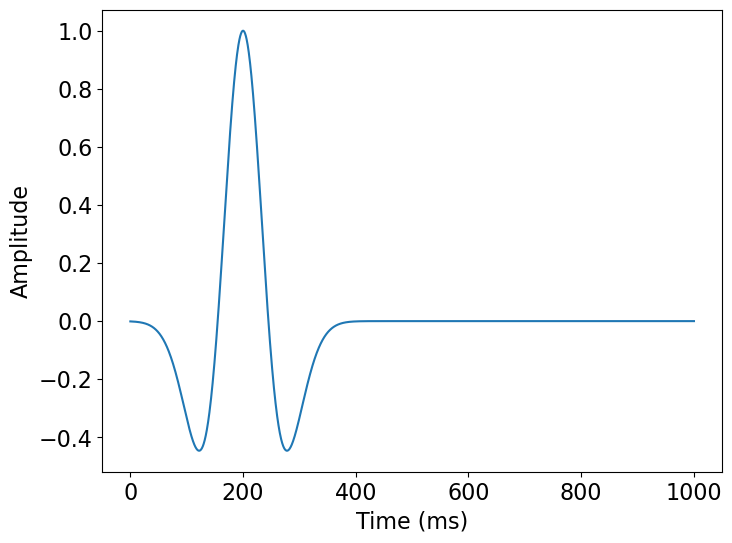

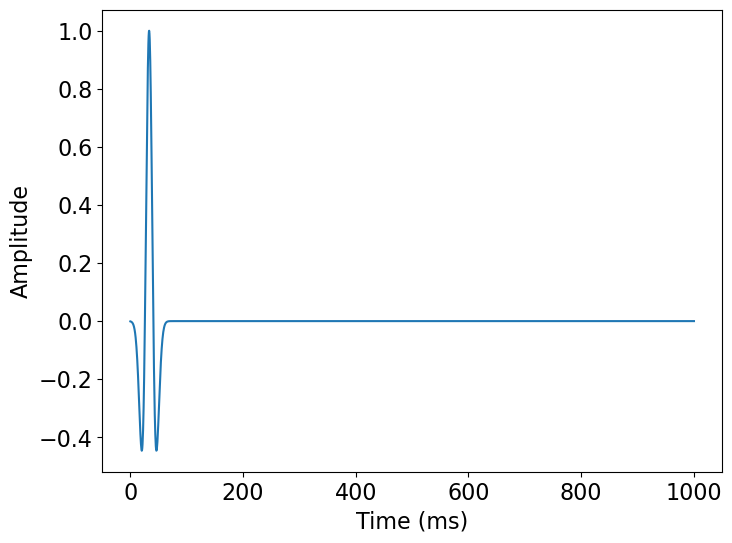

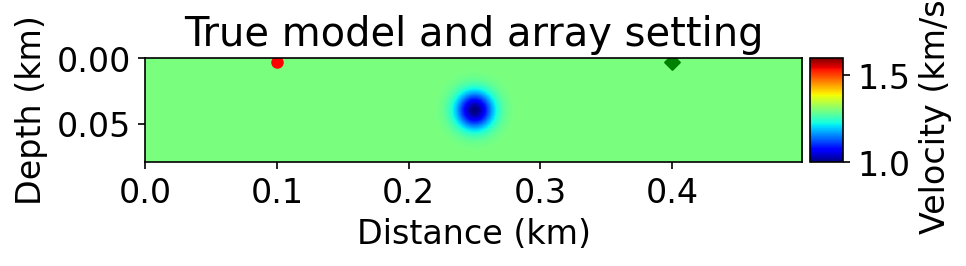

In [3]:
# Define acquisition geometry
t0 = 0
time = 1000.0
dt1 = 0.005 #KHz which means 5 Hz
dt2 = 0.03 #KHz which means 30 Hz

src_coordinates = np.empty((1, 2))
src_coordinates[0, 0] = 100
src_coordinates[0, -1] = 3

rec_coordinates = np.empty((1, 2))
rec_coordinates[:, 0] = 400
rec_coordinates[:, -1] = 3

geometry1 = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt1, src_type='Ricker')
geometry1.src.show()

geometry2 = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt2, src_type='Ricker')
geometry2.src.show()

plot_velocity_clim(true_model,vmin=v0-perturbation, vmax=v0+perturbation, name="True model and array setting", cmap="jet", source=geometry1.src_positions,receiver=geometry1.rec_positions[::4, :])

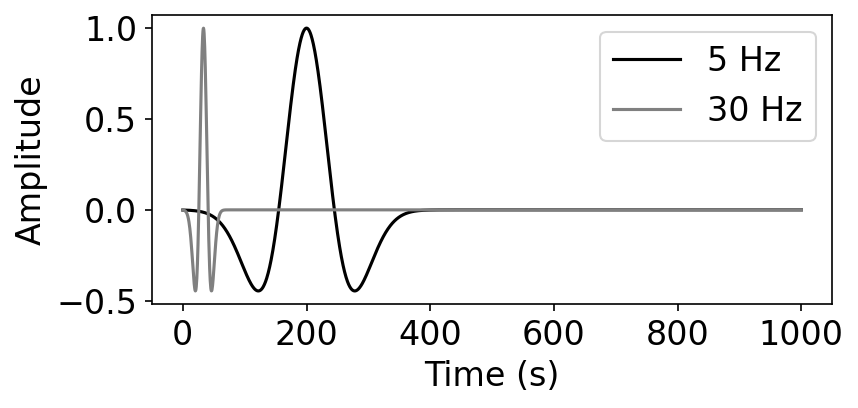

In [4]:
wavelet1 = geometry1.src.data  # 5 Hz
wavelet2 = geometry2.src.data  # 30 Hz

nt = len(wavelet1)
dt = geometry1.dt  # Time step in seconds
t = np.arange(nt) * dt

# Time-domain wavelets only
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)

ax.plot(t, wavelet1, label='5 Hz', color='black')
ax.plot(t, wavelet2, label='30 Hz', color='gray')

ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
# ax.set_title("Ricker Wavelets")
ax.legend()

plt.tight_layout()
# plt.savefig("ricker_wavelets_time.pdf", format='pdf', dpi=300)
plt.show()

In [5]:
# simulate the low and high frequency true and initial data
solver1 = AcousticWaveSolver(true_model, geometry1, space_order=4)
true_data1, _, _ = solver1.forward(vp=true_model.vp)
initial_data1, _, _ = solver1.forward(vp=start_model.vp)

solver2 = AcousticWaveSolver(true_model, geometry2, space_order=4)
true_data2, _, _ = solver2.forward(vp=true_model.vp)
initial_data2, _, _ = solver2.forward(vp=start_model.vp)

In [6]:
sigma_range = np.arange(5, 15, 1)  # Gaussian spread (analogous to radius)
vel_range = np.arange(0.7, 1.3, 0.01)  # Central anomaly velocity
errors1 = np.zeros((len(sigma_range), len(vel_range)))
errors2 = np.zeros((len(sigma_range), len(vel_range)))

velocity_base = np.full((nz, nx), v0, dtype=float)
cx, cz = nx // 2, nz // 2

for i, sigma in enumerate(sigma_range):
    for j, v_center in enumerate(vel_range):

        gaussian = (v0 - v_center) * np.exp(-((X - cx)**2 + (Z - cz)**2) / (2 * sigma**2))
        model_array = velocity_base - gaussian

        vp_model = np.transpose(model_array)
        pert_model = Model(vp=vp_model, origin=origin, shape=shape,
                           spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
        pert_data1, _, _ = solver1.forward(vp=pert_model.vp)
        pert_data2, _, _ = solver2.forward(vp=pert_model.vp)
        diff1 = true_data1.data - pert_data1.data
        diff2 = true_data2.data - pert_data2.data
        l2_error1 = np.linalg.norm(diff1)
        l2_error2 = np.linalg.norm(diff2)

        errors1[i, j] = l2_error1
        errors2[i, j] = l2_error2
        print(f"5Hz: Sigma {sigma}, velocity {v_center:.2f} → L2 Error = {l2_error1:.4f}")
        print(f"30Hz: Sigma {sigma}, velocity {v_center:.2f} → L2 Error = {l2_error2:.4f}")

5Hz: Sigma 5, velocity 0.70 → L2 Error = 0.0087
30Hz: Sigma 5, velocity 0.70 → L2 Error = 0.0142
5Hz: Sigma 5, velocity 0.71 → L2 Error = 0.0093
30Hz: Sigma 5, velocity 0.71 → L2 Error = 0.0146
5Hz: Sigma 5, velocity 0.72 → L2 Error = 0.0099
30Hz: Sigma 5, velocity 0.72 → L2 Error = 0.0151
5Hz: Sigma 5, velocity 0.73 → L2 Error = 0.0105
30Hz: Sigma 5, velocity 0.73 → L2 Error = 0.0156
5Hz: Sigma 5, velocity 0.74 → L2 Error = 0.0110
30Hz: Sigma 5, velocity 0.74 → L2 Error = 0.0163
5Hz: Sigma 5, velocity 0.75 → L2 Error = 0.0116
30Hz: Sigma 5, velocity 0.75 → L2 Error = 0.0170
5Hz: Sigma 5, velocity 0.76 → L2 Error = 0.0121
30Hz: Sigma 5, velocity 0.76 → L2 Error = 0.0178
5Hz: Sigma 5, velocity 0.77 → L2 Error = 0.0127
30Hz: Sigma 5, velocity 0.77 → L2 Error = 0.0187
5Hz: Sigma 5, velocity 0.78 → L2 Error = 0.0132
30Hz: Sigma 5, velocity 0.78 → L2 Error = 0.0196
5Hz: Sigma 5, velocity 0.79 → L2 Error = 0.0137
30Hz: Sigma 5, velocity 0.79 → L2 Error = 0.0205
5Hz: Sigma 5, velocity 0.80 → 

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_65644/3549835955.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet').copy()


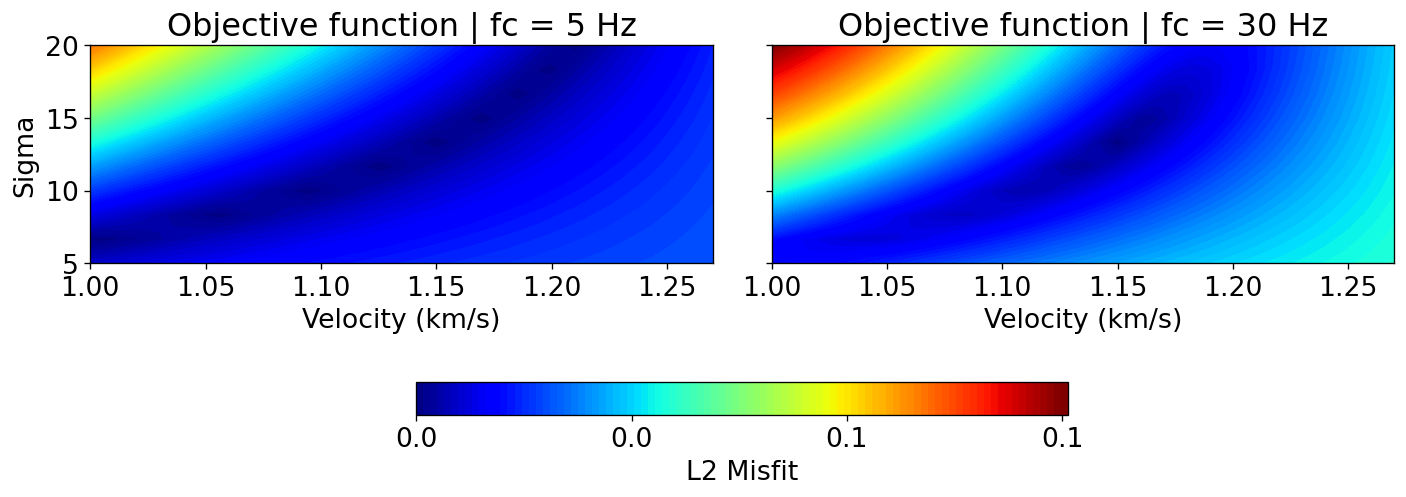

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import numpy as np

fc1 = dt1 * 1000
fc2 = dt2 * 1000

masked_errors1 = np.ma.masked_invalid(errors1)
masked_errors2 = np.ma.masked_invalid(errors2)

cmap = cm.get_cmap('jet').copy()
cmap.set_bad(color=(0, 0, 0, 0))

sigma_range = np.linspace(5, 20, errors1.shape[0])
vel_range = np.linspace(1.0, 1.3, errors1.shape[1])

vel_grid, sigma_grid = np.meshgrid(vel_range, sigma_range)


vmin = min(masked_errors1.min(), masked_errors2.min())
vmax = max(masked_errors1.max(), masked_errors2.max())

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=120, sharey=True)

# Plot for lower frequency
c1 = axs[0].contourf(vel_grid, sigma_grid, masked_errors1, levels=100,
                     cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].plot([v0, v0], [sigma_range[0], sigma_range[-1]], 'w--', linewidth=0.8)
axs[0].set_title(f'Objective function | fc = {fc1:.0f} Hz')
axs[0].set_xlabel("Velocity (km/s)")
axs[0].set_ylabel("Sigma")
axs[0].set_xlim(vel_range[0], vel_range[-1]-0.03)
axs[0].set_ylim(sigma_range[0], sigma_range[-1])

# Plot for higher frequency
c2 = axs[1].contourf(vel_grid, sigma_grid, masked_errors2, levels=100,
                     cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].plot([v0, v0], [sigma_range[0], sigma_range[-1]], 'w--', linewidth=0.8)
axs[1].set_title(f'Objective function | fc = {fc2:.0f} Hz')
axs[1].set_xlabel("Velocity (km/s)")
axs[1].set_xlim(vel_range[0], vel_range[-1]-0.03)
axs[1].set_ylim(sigma_range[0], sigma_range[-1])

plt.tight_layout(rect=[0, 0.07, 1, 1])  # Leave space at bottom for colorbar

# Colorbar
cbar = fig.colorbar(c2, ax=axs.ravel().tolist(), label='L2 Misfit',
                    orientation='horizontal', shrink=0.5, pad=0.3)
ticks = np.linspace(vmin, vmax, 4)
cbar.set_ticks(ticks)
cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Save or show
# plt.savefig("objective_surface.pdf", format='pdf', dpi=300)
plt.show()